# __1-D DFT Code for harmonic Osciilator__

### Testing the Derivative operator

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

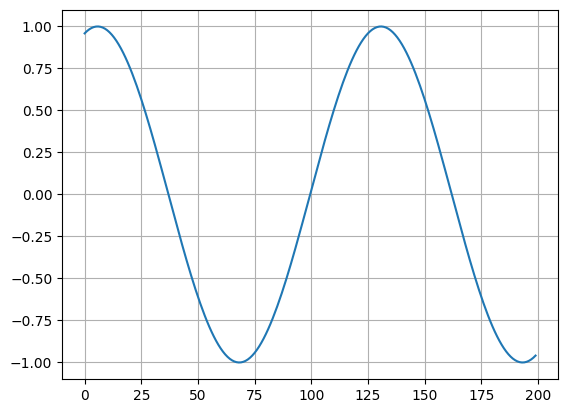

In [27]:
n_grid=200
x=np.linspace(-5,5,n_grid)
y=np.sin(x)
plt.plot(y)
plt.grid()
h=x[1]-x[0]

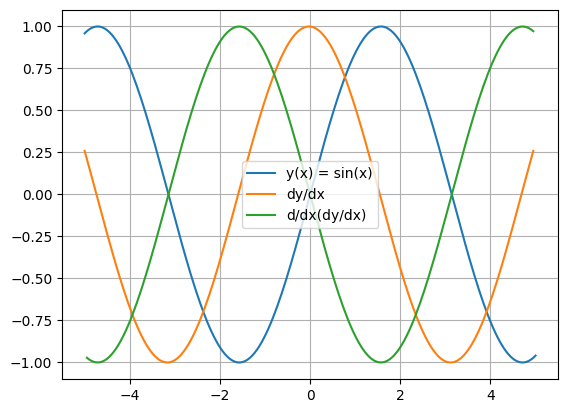

In [28]:
D=-np.eye(n_grid)+np.diagflat(np.ones(n_grid-1),1)
D = D / h

D2=D.dot(-D.T)
D2[-1,-1]=D2[0,0]


plt.plot(x,y, label="y(x) = sin(x)")
plt.plot(x[:-1],D.dot(y)[:-1], label=r"dy/dx")
plt.plot(x[1:-1],D2.dot(y)[1:-1], label=r"d/dx(dy/dx)")
plt.grid()
plt.legend()

## __1D Harmonic Oscillator__

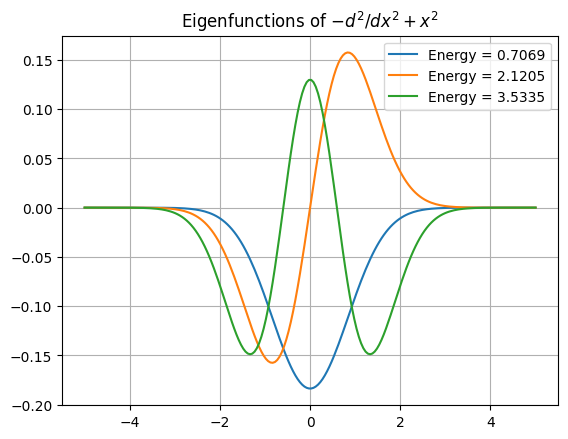

In [34]:
X=np.diagflat(x*x)
eig_harm, psi_harm = np.linalg.eigh(-D2/2+X)
for i in range(3):
    plt.plot(x,psi_harm[:,i], label=f"Energy = {eig_harm[i]:.4f}")
plt.legend(loc=1)
plt.title("Eigenfunctions of $-d^2/dx^2 + x^2$")
plt.grid()
